In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, folder_path, label, transform=None):
        self.folder_path = folder_path
        self.label = label
        self.transform = transform
        self.images = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure image is RGB
        if self.transform:
            image = self.transform(image)
        return image, self.label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Paths and labels
normal_path = "/content/drive/MyDrive/SEM 5/Minor project/Online dataset/ initial/ECG_IMAGES_DATASETS/NP"
abnormal_path = "/content/drive/MyDrive/SEM 5/Minor project/Online dataset/ initial/ECG_IMAGES_DATASETS/AH"
MI_path = "/content/drive/MyDrive/SEM 5/Minor project/Online dataset/ initial/ECG_IMAGES_DATASETS/MI"
history_MI_path = "/content/drive/MyDrive/SEM 5/Minor project/Online dataset/ initial/ECG_IMAGES_DATASETS/HMI"

# Labels (e.g., 0 for normal, 1 for abnormal, etc.)
normal_dataset = CustomDataset(normal_path, label=0, transform=transform)
abnormal_dataset = CustomDataset(abnormal_path, label=1, transform=transform)
MI_dataset = CustomDataset(MI_path, label=2, transform=transform)
history_MI_dataset = CustomDataset(history_MI_path, label=3, transform=transform)

# Combine datasets
from torch.utils.data import ConcatDataset

combined_dataset = ConcatDataset([normal_dataset, abnormal_dataset, MI_dataset, history_MI_dataset])

# Split into training and validation datasets
from torch.utils.data import random_split

train_size = int(0.8 * len(combined_dataset))  # 80% training
val_size = len(combined_dataset) - train_size  # 20% validation
train_data, val_data = random_split(combined_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Example: Using ResNet18
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)  # 4 classes: normal, abnormal, MI, history_MI
model = model.to("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import torch
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Lists to store loss and accuracy data
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Plotting the results
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/10
Train Loss: 0.8089, Train Accuracy: 0.7399
Validation Loss: 3.2566, Validation Accuracy: 0.5860
Epoch 2/10
Train Loss: 0.4127, Train Accuracy: 0.8625
Validation Loss: 0.5633, Validation Accuracy: 0.8333
Epoch 3/10
Train Loss: 0.1915, Train Accuracy: 0.9353
Validation Loss: 0.5981, Validation Accuracy: 0.7957
Epoch 4/10
Train Loss: 0.2214, Train Accuracy: 0.9232
Validation Loss: 1.1125, Validation Accuracy: 0.7581
Epoch 5/10
Train Loss: 0.1706, Train Accuracy: 0.9555
Validation Loss: 0.5901, Validation Accuracy: 0.8441
Epoch 6/10
Train Loss: 0.0962, Train Accuracy: 0.9730
Validation Loss: 0.1330, Validation Accuracy: 0.9785
Epoch 7/10
Train Loss: 0.0938, Train Accuracy: 0.9663
Validation Loss: 0.6002, Validation Accuracy: 0.8118
Epoch 8/10
Train Loss: 0.1335, Train Accuracy: 0.9488
Validation Loss: 0.4598, Validation Accuracy: 0.8710
Epoch 9/10
Train Loss: 0.1041, Train Accuracy: 0.9717
Validation Loss: 0.2972, Validation Accuracy: 0.9301
Epoch 10/10
Train Loss: 0.0707, Train

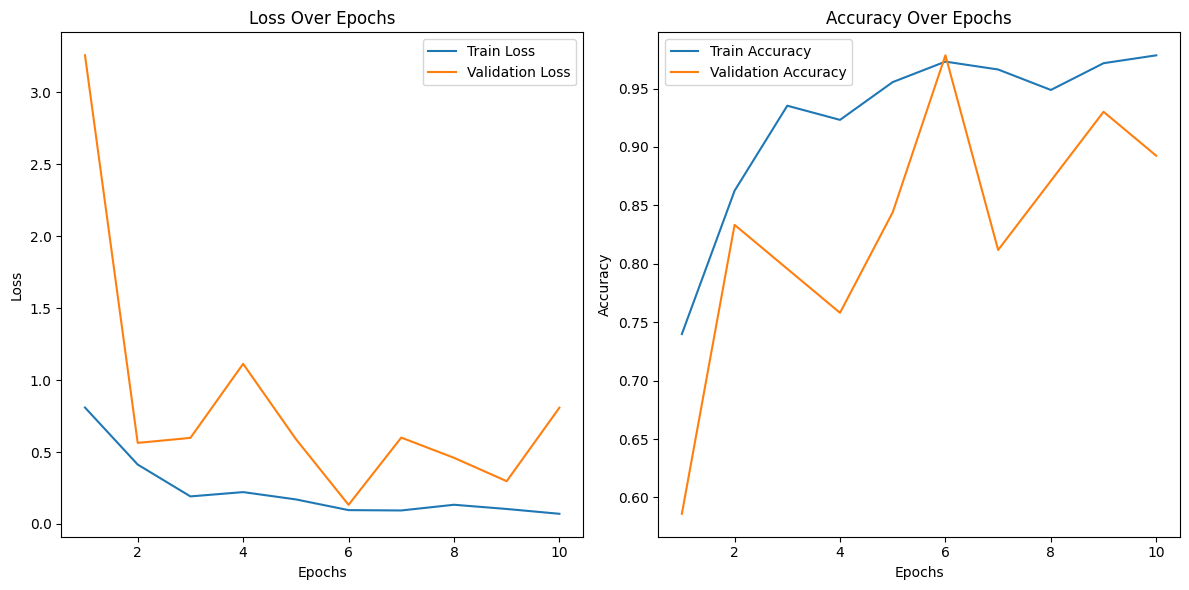

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SEM 5/Minor project/Online dataset/RESNET.pth')


In [ ]:
from google.colab import files
files.download('/content/drive/MyDrive/SEM 5/Minor project/Online dataset/RESNET.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>